# BERTopic

## imports and preliminaries

In [1]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download('punkt_tab')

path_to_data = "./text_chunks.tsv"
stopwords = stopwords.words("english")
stopwords.extend(["the", "in", "of"])

#print(stopwords)

# Open training data
training_data = pd.read_csv(path_to_data, sep="\t", header=0)

# Tokenise text and remove stopwords
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: word_tokenize(x))
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: ' '.join([word for word in x if word.lower() not in stopwords]))

#training_data.head(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## So, is there an ERNIETopic?

In [2]:
# prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(training_data["TEXT"], show_progress_bar=True)
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# Train BERTopic
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(training_data["TEXT"])
hierarchical_topics = topic_model.hierarchical_topics(training_data["TEXT"])

# Save model
topic_model.save("./output/bertopic_model", serialization="safetensors", save_ctfidf=True)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-11-18 16:11:38,199 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

2024-11-18 16:11:50,243 - BERTopic - Embedding - Completed ✓
2024-11-18 16:11:50,244 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-18 16:11:56,047 - BERTopic - Dimensionality - Completed ✓
2024-11-18 16:11:56,048 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-18 16:11:56,113 - BERTopic - Cluster - Completed ✓
2024-11-18 16:11:56,120 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-18 16:11:56,232 - BERTopic - Representation - Completed ✓
100%|██████████| 50/50 [00:00<00:00, 771.32it/s]


In [19]:
topic_model.get_document_info(training_data["TEXT"])

similar_topics, similarity = topic_model.find_topics("composition", top_n=5)
topic_model.get_topic(similar_topics[0])

titles = topic_model.get_topic_info()
print(titles["Name"].values)

['-1_one_poetry_verse_life' '0_art_aesthetic_artist_form'
 '1_women_men_woman_life' '2_light_sleep_flowers_thee'
 '3_enemy_men_yards_front' '4_mr_brown_mrs_bennett'
 '5_verlaine_fame_glory_love'
 '6_composition_everything_different_naturally'
 '7_etheredge_hobart_temple_wilmot' '8_fitzjames_george_sir_father'
 '9_ibsen_hedda_play_nt' '10_poetry_poets_books_verse'
 '11_russia_economic_religion_soviet' '12_music_musical_sound_notes'
 '13_highbrow_highbrows_frankau_altifrons' '14_eight_chapter_ii_iii'
 '15_bentuas_stage_shakespeare_passage' '16_colonel_yes_regiment_sailor'
 '17_delius_composer_music_choral' '18_english_language_spelling_french'
 '19_sol_1st_2nd_sir' '20_heltubada_verse_blank_prose'
 '21_international_order_force_justice' '22_halve_put_literally_know'
 '23_film_cinema_shot_films' '24_dryden_would_boyle_though'
 '25_sailor_ad_padre_sir' '26_wing_conservative_left_liberal'
 '27_heltubada_certainly_admit_hm' '28_astray_land_supposing_mine'
 '29_blank_verse_prose_bentuas' '30_

11-18-18:52


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


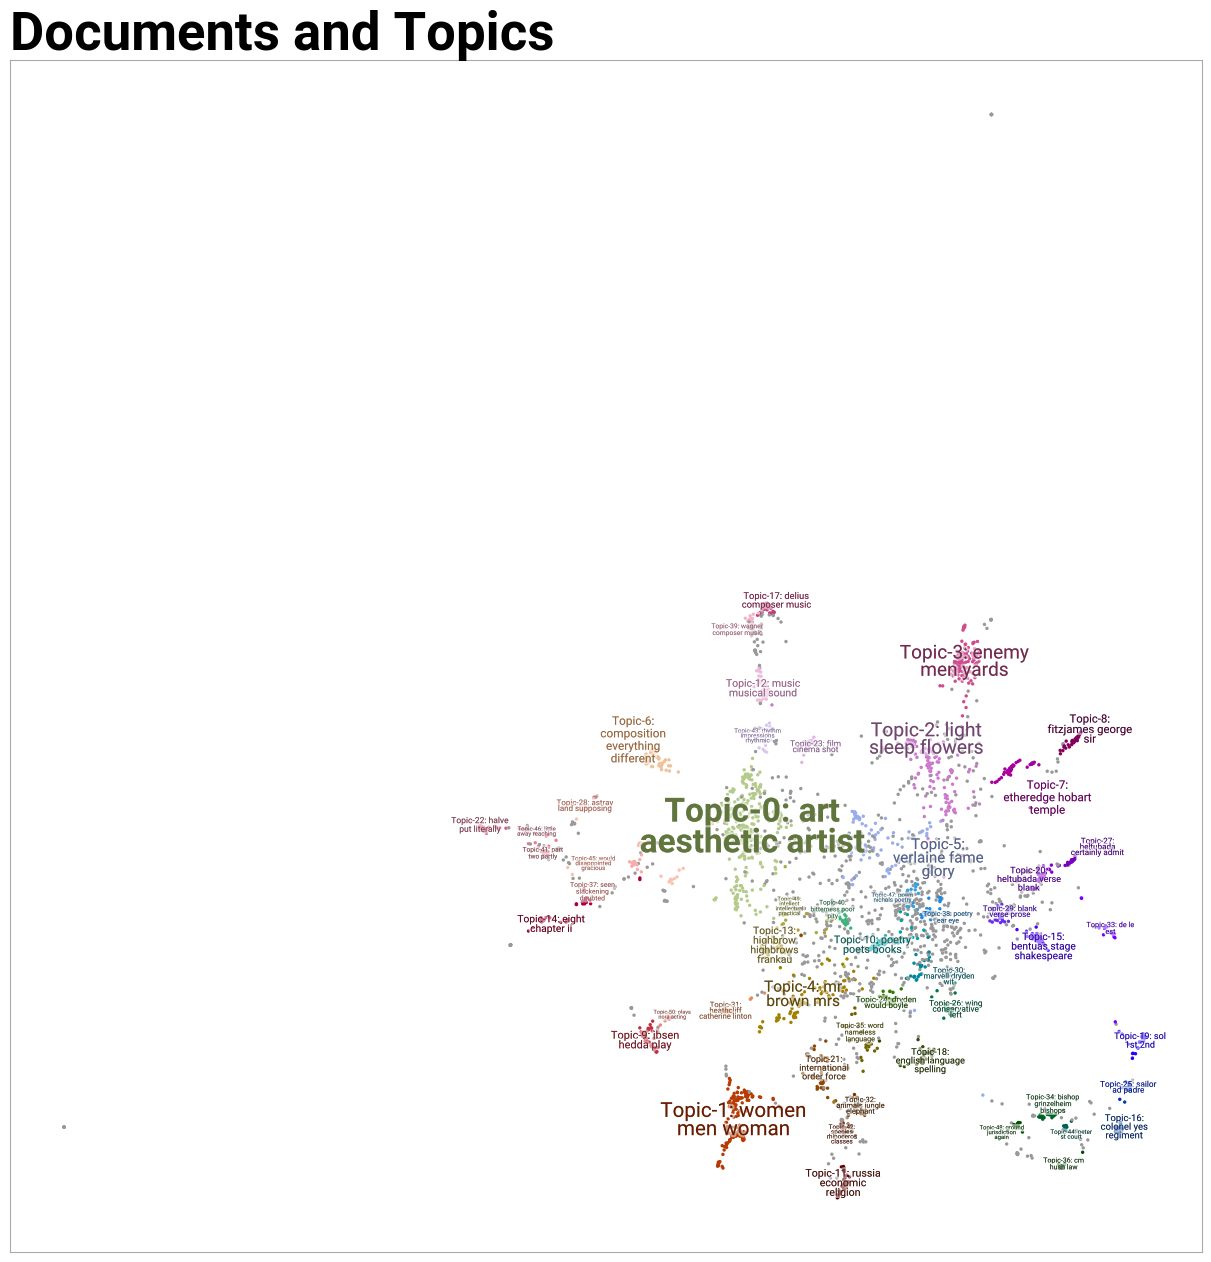

In [26]:
# loading stuff and creating data to feed to the visualisation

from datetime import datetime

time = datetime.now()
timestamp = time.strftime("%m-%d-%H:%M")
print(timestamp)

topic_model.load("./output/bertopic_model")
docs = training_data["TEXT"]
topic_info = topic_model.get_topic_info()
highlight_labels = topic_info["Name"].values

#reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

# generate datamap

datamap = topic_model.visualize_document_datamap(
  docs, 
  reduced_embeddings=reduced_embeddings,
  label_over_points=True, 
  dynamic_label_size=True,
  highlight_labels=highlight_labels,
    highlight_label_keywords={
        "fontweight":1000, "bbox":{"boxstyle":"circle", "pad":1.0, "alpha":0.15},
    },
  add_glow=False
  )

# save datamap

datamap.savefig(f"./output/visualisations/datamap_{timestamp}.png", dpi=300)